# 10 階層ベイズモデル -GLMMのベイズモデル化-
- [Pythonで実装しながら緑本を学ぶ (第10章 階層ベイズモデル)](https://ohke.hateblo.jp/entry/2018/03/21/230000)

In [6]:
import requests
import zipfile
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline
%precision 3

'%.3f'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

### 10.1 例題：個体差と生存種子数(個体差あり)

In [36]:
file_path = './data/data7a.csv'

if not os.path.isfile(file_path):
  response = requests.get('https://kuboweb.github.io/-kubo/stat/iwanamibook/fig/hbm/data7a.csv')
  with open (file_path, 'wb') as f:
      f.write(response.content)
      f.close()

In [8]:
data = pd.read_csv('./data/data7a.csv')
data.head(3)

,id,y
0,1,0
1,2,2
2,3,7


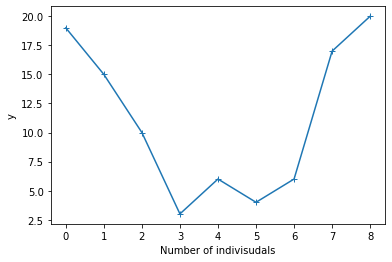

In [11]:
plt.plot(data.y.value_counts().sort_index(), marker='+')
plt.xlabel('Number of indivisudals')
plt.ylabel('y')
plt.show()

In [12]:
print('平均: ', data.y.mean())
print('分散: ', data.y.var())

平均:  4.03
分散:  9.928383838383839


### 10.2 GLMMの階層ベイズモデル化

### 10.3 階層ベイズモデルの推定・予測

In [13]:
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [17]:
with pm.Model() as model:
    # βの事前分布をN(0, 100)の正規分布で設定(無情報事前分布)
    beta = pm.Normal('beta', mu=0, sd=100)
    
    # 超パラメータsの(超)事前分布をU(0, 10000)の連続一様分布で設定(無情報事前分布)
    s = pm.Uniform('s', lower=0, upper=10000)
    
    # パラメータrの事前分布をN(0, s)の正規分布で設定(階層事前分布)
    r = pm.Normal('r', mu=0, sd=s, shape=len(data.y))
    
    # ロジットリンク関数を設定し、二項分布で推定する
    y = pm.Binomial('y', n=8, p=pm.invlogit(beta + r), observed=data.y.values)

Multiprocess sampling (3 chains in 3 jobs)
NUTS: [r, s, beta]


Sampling 3 chains for 100 tune and 1_500 draw iterations (300 + 4_500 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9356739280713503, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9402942499551096, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9458921060590438, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.032,0.340,-0.635,0.621,0.013,0.010,644.0,1127.0,1.0
r[0],-3.886,1.821,-7.227,-0.673,0.029,0.025,5134.0,2483.0,1.0
r[1],-1.191,0.874,-2.919,0.350,0.016,0.013,2930.0,2670.0,1.0
r[2],2.008,1.112,0.033,4.192,0.019,0.015,3704.0,2842.0,1.0
r[3],3.827,1.797,0.806,7.254,0.031,0.025,4358.0,2688.0,1.0
...,...,...,...,...,...,...,...,...,...
r[96],-3.886,1.808,-7.310,-0.897,0.030,0.024,4265.0,2689.0,1.0
r[97],-0.026,0.815,-1.511,1.511,0.017,0.012,2398.0,2810.0,1.0
r[98],1.998,1.101,0.055,4.109,0.020,0.015,3319.0,2893.0,1.0
r[99],-3.879,1.788,-7.200,-0.806,0.026,0.023,6028.0,3237.0,1.0


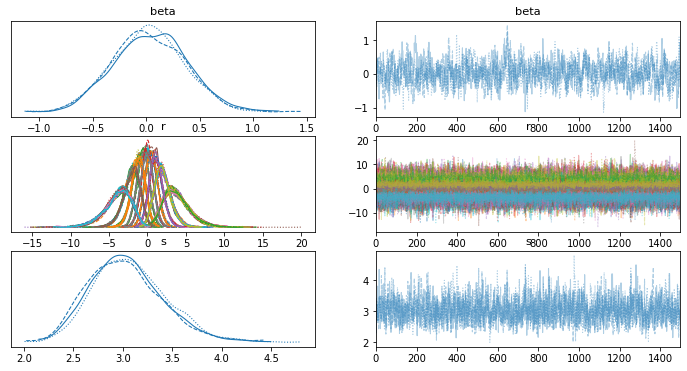

In [19]:
with model:
  trace = pm.sample(1500, step=pm.NUTS(), tune=100, cores=3)

pm.traceplot(trace)
pm.summary(trace)

In [22]:
from scipy.stats import binom, norm

# 事後分布p(β|Y), p(s|Y)を3つのサンプル列の平均値で求める
beta_averages = np.zeros(len(trace), dtype=np.float64)
s_averages = np.zeros(len(trace), dtype=np.float64)

for i in trace.chains:
    beta_averages += trace.get_values('beta', chains=i) / trace.nchains
    s_averages += trace.get_values('s', chains=i) / trace.nchains

# シグモイド関数
q = lambda beta, r: 1 / (1 + math.exp(-(beta + r)))

# 全サンプル・全個体の種子数yの生存確率を計算
probs = []

for (beta, s) in zip(beta_averages, s_averages):
    individuals_probs = []
    
    # 100個体を生成
    for r in norm.rvs(loc=0, scale=s, size=100):
        y_probs = []
        
        # 各個体の種子数(0〜8個)の生存確率を計算
        for y in range(9):
            y_probs.append(binom.pmf(y, 8, q(beta, r)))
            
        individuals_probs.append(y_probs)
        
    probs.append(individuals_probs)
    
probs = np.array(probs)

# βx1500, sx1500
# rx100
# b, r, sの時の種子数(0~8)の確率を求める
print(probs.shape) # (1500, 100, 9)

(1500, 100, 9)


In [32]:
# 種子数(0~8)の平均を求めている
np.average(np.average(probs, axis=1), axis=0)

array([0.215, 0.106, 0.077, 0.067, 0.064, 0.067, 0.078, 0.107, 0.22 ])

Text(0, 0.5, 'y')

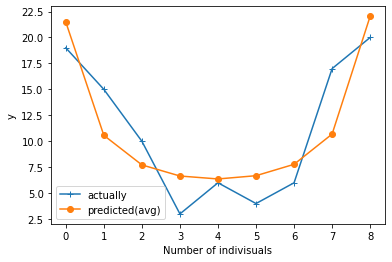

In [25]:
plt.plot(data.y.value_counts().sort_index(), marker='+', label='actually')
plt.plot(np.average(np.average(probs, axis=1), axis=0) * 100, marker='o', label='predicted(avg)')
plt.legend()
plt.xlabel('Number of indivisuals')
plt.ylabel('y')

### 10.5 個体差＋場所差の階層ベイズモデル

In [40]:
file_path = './data/d1.csv'

if not os.path.isfile(file_path):
  response = requests.get('https://kuboweb.github.io/-kubo/stat/iwanamibook/fig/hbm/nested/d1.csv')
  with open (file_path, 'wb') as f:
      f.write(response.content)
      f.close()

In [41]:
data = pd.read_csv(file_path)
data.head()

,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0


Text(0, 0.5, 'y')

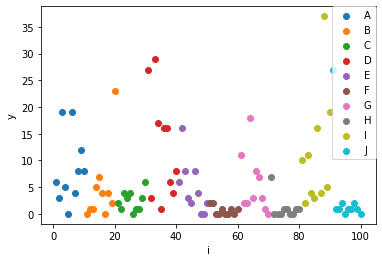

In [43]:
# 個体ごとの分布をプロット(ポット別に色分け)
for pot in data.pot.unique():
  plt.scatter(data[data.pot == pot].id, data[data.pot == pot].y, label=pot)
plt.legend(loc='upper right', borderaxespad=0)
plt.xlabel('i')
plt.ylabel('y')

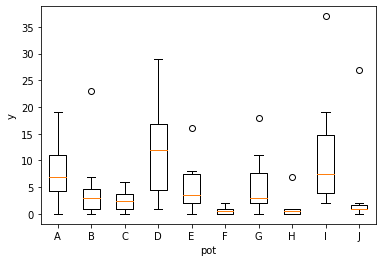

In [46]:
# 植木鉢ごとの分布を箱ひげ図でプロット
plt.boxplot([data[data.pot == p].y for p in data.pot.unique()], labels=data.pot.unique())
plt.xlabel('pot')
plt.ylabel('y')
plt.show()

In [54]:
# T(施肥処理あり)の場合に１となる変数Fを追加
data['F'] = pd.get_dummies(data.f)['T'] # ['C]と指定すると,Cの場合に1となる
# A~Jを0~9に対応付けた変数POTを追加
data['POT'] = data.pot.apply(lambda p: ord(p) - ord('A'))

In [55]:
data.head()

,id,pot,f,y,F,POT
0,1,A,C,6,0,0
1,2,A,C,3,0,0
2,3,A,C,19,0,0
3,4,A,C,5,0,0
4,5,A,C,0,0,0


In [63]:
with pm.Model() as model:
    # β1とβ2の事前分布をN(0, 100)の正規分布で設定(無情報事前分布)
    beta1 = pm.Normal('beta1', mu=0, sd=100)
    beta2 = pm.Normal('beta2', mu=0, sd=100)
    
    # sとspの(超)事前分布をU(0, 10000)の連続一様分布で設定(無情報事前分布)
    s = pm.Uniform('s', lower=0, upper=10000)
    sp = pm.Uniform('sp', lower=0, upper=10000)
    
    # 個体差パラメータrの事前分布をN(0, s)の正規分布で設定(階層事前分布)
    r = pm.Normal('r', mu=0, sd=s, shape=len(data.y))
    
    # 場所差パラメータrpの事前分布をN(0, sp)の正規分布で設定(階層事前分布)
    rp = pm.Normal('rp', mu=0, sd=sp, shape=len(data.POT.unique()))
    
    # ログリンク関数を設定し、ポアソン分布で推定する
    y = pm.Poisson('y', mu=np.exp(beta1 + beta2 * data.F + r + rp[data.POT]), observed=data.y.values)

In [64]:
# HMCでサンプリング
with model:
    # 101個目からサンプルを取得するチェインを3つ作る
    trace = pm.sample(1500, step=pm.HamiltonianMC(), tune=100, cores=3, random_seed=0)

Multiprocess sampling (3 chains in 3 jobs)
HamiltonianMC: [rp, r, sp, s, beta2, beta1]


Sampling 3 chains for 100 tune and 1_500 draw iterations (300 + 4_500 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.9195350476279045, but should be close to 0.65. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9143239213160808, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9220587590553496, but should be close to 0.65. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,1.342,0.535,0.332,2.355,0.017,0.012,1061.0,1476.0,1.00
beta2,-0.831,0.752,-2.301,0.518,0.023,0.017,1119.0,1380.0,1.00
s,1.019,0.116,0.810,1.234,0.003,0.002,1632.0,2335.0,1.00
sp,1.011,0.366,0.466,1.704,0.014,0.010,598.0,1598.0,1.01


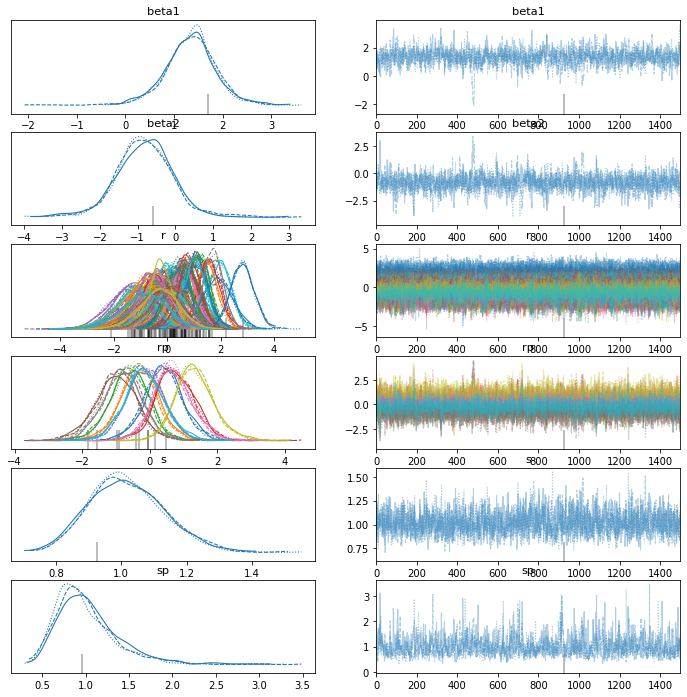

In [65]:
pm.traceplot(trace)
pm.summary(trace).loc[['beta1', 'beta2', 's', 'sp']]